## COGS 182 Homework 7
Malachi Mabie 
3 March 2021

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

##Question 1 (4 points)
Use n-step TD to learn the values of a modified version of Example 6.2 Random Walk.  Instead of 5 states, there are now 19 states like in chapter 7. The starting state is still the middle state, and the probability of right and left are both 0.5. Use n = [1, 4, 16, 64] with alpha = 0.1 to plot 4 curves of the empirical RMS error averaged over states for the first 100 episodes. (Averaging over 100 runs for each step will make the curve more smooth.)  

#### Helper functions

In [2]:
# credit to TA Dan Acosta-Kane
def create_step(num_states):

    def step(state):

        if np.random.random() > 0.5:
            state_new = state + 1
        else:
            state_new = state - 1

        r = 0
        if state_new == num_states:
            r = 1
            state_new = 0

        return state_new, r
    
    return step

In [6]:
def run_episode_nstep_TD(step, start_state, values, n, alpha, gamma):
    
    #Keep track of state and reward at each t
    state_trajectory  = []
    reward_trajectory = []
                
    state = start_state
    state_trajectory.append(state)
    reward_trajectory.append(0)
    
    #Step through episode
    for t in range(10000):# 10000 is max steps

        #Take one step
        state_new, r = step(state)
        state_trajectory.append(state_new)
        reward_trajectory.append(r)
        state = state_new

        #n step backup if not in terminal state
        if t >= n-1 and state !=0:
            # tau = t-n+1. time who's state estimate is being updated
            state_update = state_trajectory[t-n+1]

            G = 0
            #iterate back over the nsteps of the backup adding reward
            for tau in range(0, n):
                    G += gamma**tau * reward_trajectory[t-n+tau+2]
            
            #add discounted value of the final state
            G += gamma**n * values[state_new]
            
            #update desired state value
            values[state_update] += alpha * (G - values[state_update])


        #if in terminal state complete all back
        if state == 0:

            G = 0  
            for i in range(n):
                # G as a function of the relevant reward and discounted old G
                G = reward_trajectory[t+1-i] + gamma*G

                state_update = state_trajectory[t-i]
                #update desire state
                values[state_update] += alpha*(G - values[state_update])

                if t-i == 0:
                    break
            break
            
    return values

In [12]:
num_states = 19+1 # endzone
start_state = np.int(num_states/2)
true_values = np.linspace(0,1,num_states+1)[:-1]
step = create_step(num_states)

alpha  = 0.1
ns     = [1,4,16,64] # possible values for n
lmbdas = [0,0.5,0.9,1]
gamma  = 1.0

num_runs = 100
num_episodes = 100

#Store the RMS for each run
td_RMS        = np.zeros([len(ns), num_runs, num_episodes+1])
lmbda_RMS     = np.zeros([len(ns), num_runs, num_episodes+1])
# the core is capturing this value ^


#n-step TD
for i, n in tqdm(enumerate(ns)):
    for j in range(num_runs):
    
        #Initialize values
        values          = np.zeros(num_states)
        values[0]       = 0          
        td_RMS[i, j, 0] = np.sqrt(np.sum((values-true_values)**2)/len(values))

        #Loop through episodes while updating values
        for k in range(num_episodes):

            values = run_episode_nstep_TD(step, start_state, values, n, alpha,gamma) 
            td_RMS[i, j, k+1] = np.sqrt(np.sum((values-true_values)**2) / len(values)) 


4it [00:16,  4.20s/it]


##Question 2 (4 points)
Use TD(λ) to learn the values of the same modified version of Example 6.2 Random Walk. Use λ = [0, 0.1, 0.5, 1] with alpha = 0.1 to plot 4 curves of the empirical RMS error averaged over states of the first 100 episodes.

In [8]:
def run_episode_TD_lmbda(step, start_state, values, lmdba, alpha, gamma):
    
    #initialize weights and starting state
    e_weights = np.zeros(len(values))
    state = start_state
   
    for t in range(10000):
        
        state_new, r      = step(state)
        td_error          = r + gamma*values[state_new] - values[state]
        e_weights[state]  = 1 #replacing traces
        
        #update values and eligibility weights
        values           += alpha * td_error * e_weights
        e_weights         = gamma * lmbda * e_weights
        
        state             = state_new 
        
        if state == 0:
            break
        
    return values

In [13]:
#TD lambda            
for i, lmbda in tqdm(enumerate(lmbdas)):
  for j in range(num_runs):

    #Initialize values
    values = np.zeros(num_states)
    values[0] = 0
    lmbda_RMS[i, j, 0] = np.sqrt(np.sum((values-true_values)**2)/len(values))

    #Loop through episodes while updating values
    for k in range(num_episodes):

        values = run_episode_TD_lmbda(step, start_state, values, lmbda, alpha, gamma)
        lmbda_RMS[i, j, k+1] = np.sqrt(np.sum((values-true_values)**2)/len(values)) 

4it [00:23,  5.95s/it]


## Plots

Text(0, 0.5, 'Empirical RMS error')

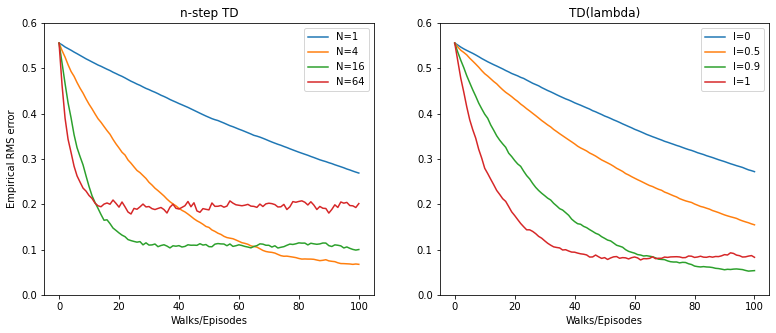

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

for i in range(4):
    
    ax[0].plot(np.mean(td_RMS[i,:,:], axis=(0)).T, label = "N=" + str(ns[i]) )
    ax[1].plot(np.mean(lmbda_RMS[i,:,:], axis=(0)).T, label = "l=" + str(lmbdas[i]))
    
for i in range(2):
    ax[i].legend()
    ax[i].set_ylim(ymin=0, ymax=0.6)
    ax[i].set_xlabel("Walks/Episodes")

ax[0].title.set_text("n-step TD")
ax[1].title.set_text("TD(lambda)")
ax[0].set_ylabel("Empirical RMS error")

##Question 3 (2 points)
How do n-step TD, TD(lambda), and Monte Carlo methods relate to each other? Under what parameter settings are some versions of the algorithms equivalent? What does this say about the curves plotted in questions 1 and 2?


 > n step TD matches Monte Carlo when n is equal to the longest episode length.